## Libraries

In [3]:
from scipy.stats import norm
import kagglehub
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt

## Functions

In [4]:
# Enable copy-on-write mode for pandas DataFrames
pd.set_option("mode.copy_on_write", True)


# Downloads and loads the dataset from Kaggle and returns the CSV path
def download_data():
    path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
    files = os.listdir(path)
    csv_file = files[0]
    return os.path.join(path, csv_file)


# Reads in the dataset
def load_data(csv_path: str) -> pd.DataFrame:
    return pd.read_csv(csv_path, encoding="ISO-8859-1")

## Data

In [5]:
data_ = load_data(download_data())
print(data_.shape)
data_.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
df = data_[["default.payment.next.month", "LIMIT_BAL", "ID"]].copy()
df.rename(
    columns={
        "LIMIT_BAL": "CREDIT_LINE",
        "default.payment.next.month": "DEFAULT_STATUS",
    },
    inplace=True,
)
print(df.shape)
df.head()

(30000, 3)


,DEFAULT_STATUS,CREDIT_LINE,ID
0,1,20000.0,1
1,1,120000.0,2
2,0,90000.0,3
3,0,50000.0,4
4,0,50000.0,5


In [7]:
credit_lines = df.CREDIT_LINE.values
credit_lines

array([ 20000., 120000.,  90000., ...,  30000.,  80000.,  50000.])

## Simulations

In [8]:
correlations = [0.05, 0.10, 0.15]
default_rates = [0.10, 0.105, 0.11, 0.115, 0.12]
n_simulations = 1000
N = len(credit_lines)

results = []

In [9]:
for correlation_factor in correlations:
    for payment_default in default_rates:
        print(f"\n{'='*60}")
        print(
            f"Running simulation: ρ={correlation_factor:.1%}, PD={payment_default:.1%}"
        )
        print(f"{'='*60}")

        # Computing threshold for current PD
        threshold = norm.ppf(payment_default)

        # Arrays for saving the current results
        total_losses = np.zeros(n_simulations)
        n_user_default = np.zeros(n_simulations)

        # Monte Carlo Simulation
        for i in range(n_simulations):
            systematic_factor = np.random.normal(0, 1)
            idiosyncratic_factor = np.random.normal(0, 1, N)

            # Vasicek Formula
            X = (
                np.sqrt(correlation_factor) * systematic_factor
                + np.sqrt(1 - correlation_factor) * idiosyncratic_factor
            )

            flag = (X < threshold).astype(int)
            n_user_default[i] = np.sum(flag)
            total_losses[i] = np.sum(flag * credit_lines)

        # Compute risk metrics
        expected_loss = np.mean(total_losses)
        mean_default_rate = np.mean(n_user_default) / N

        # VaR y CVaR for different confidence levels
        confidence_levels = [90, 95, 99]
        var_results = {}
        cvar_results = {}

        for confidence in confidence_levels:
            var = np.percentile(total_losses, confidence)
            cvar = np.mean(total_losses[total_losses >= var])
            var_results[confidence] = var
            cvar_results[confidence] = cvar

        result = {
            "correlation": correlation_factor,
            "pd": payment_default,
            "expected_loss": expected_loss,
            "mean_default_rate": mean_default_rate,
            "var_90": var_results[90],
            "var_95": var_results[95],
            "var_99": var_results[99],
            "cvar_90": cvar_results[90],
            "cvar_95": cvar_results[95],
            "cvar_99": cvar_results[99],
            "max_loss": np.max(total_losses),
            "min_loss": np.min(total_losses),
            "total_losses": total_losses.copy(),  # For plotting
        }
        results.append(result)

        print(f"Default Rate: {payment_default:.1%}")
        print(f"Correlation: {correlation_factor:.1%}")
        print(f"Mean default rate: {mean_default_rate:.2%}")
        print(f"Expected Loss: NT${expected_loss:,.2f}")
        print(f"VaR 95%: NT${var_results[95]:,.2f}")
        print(f"CVaR 95%: NT${cvar_results[95]:,.2f}")


Running simulation: ρ=5.0%, PD=10.0%
Default Rate: 10.0%
Correlation: 5.0%
Mean default rate: 9.99%
Expected Loss: NT$502,130,916.32
VaR 95%: NT$862,732,684.00
CVaR 95%: NT$1,032,492,870.40

Running simulation: ρ=5.0%, PD=10.5%
Default Rate: 10.5%
Correlation: 5.0%
Mean default rate: 10.59%
Expected Loss: NT$531,827,830.88
VaR 95%: NT$921,047,300.00
CVaR 95%: NT$1,034,216,123.20

Running simulation: ρ=5.0%, PD=11.0%
Default Rate: 11.0%
Correlation: 5.0%
Mean default rate: 11.05%
Expected Loss: NT$554,919,748.64
VaR 95%: NT$951,894,296.00
CVaR 95%: NT$1,119,959,249.60

Running simulation: ρ=5.0%, PD=11.5%
Default Rate: 11.5%
Correlation: 5.0%
Mean default rate: 11.46%
Expected Loss: NT$575,766,566.64
VaR 95%: NT$975,336,796.00
CVaR 95%: NT$1,150,632,049.60

Running simulation: ρ=5.0%, PD=12.0%
Default Rate: 12.0%
Correlation: 5.0%
Mean default rate: 12.10%
Expected Loss: NT$608,033,485.20
VaR 95%: NT$1,001,193,384.00
CVaR 95%: NT$1,136,809,176.00

Running simulation: ρ=10.0%, PD=10.0%


### Plots

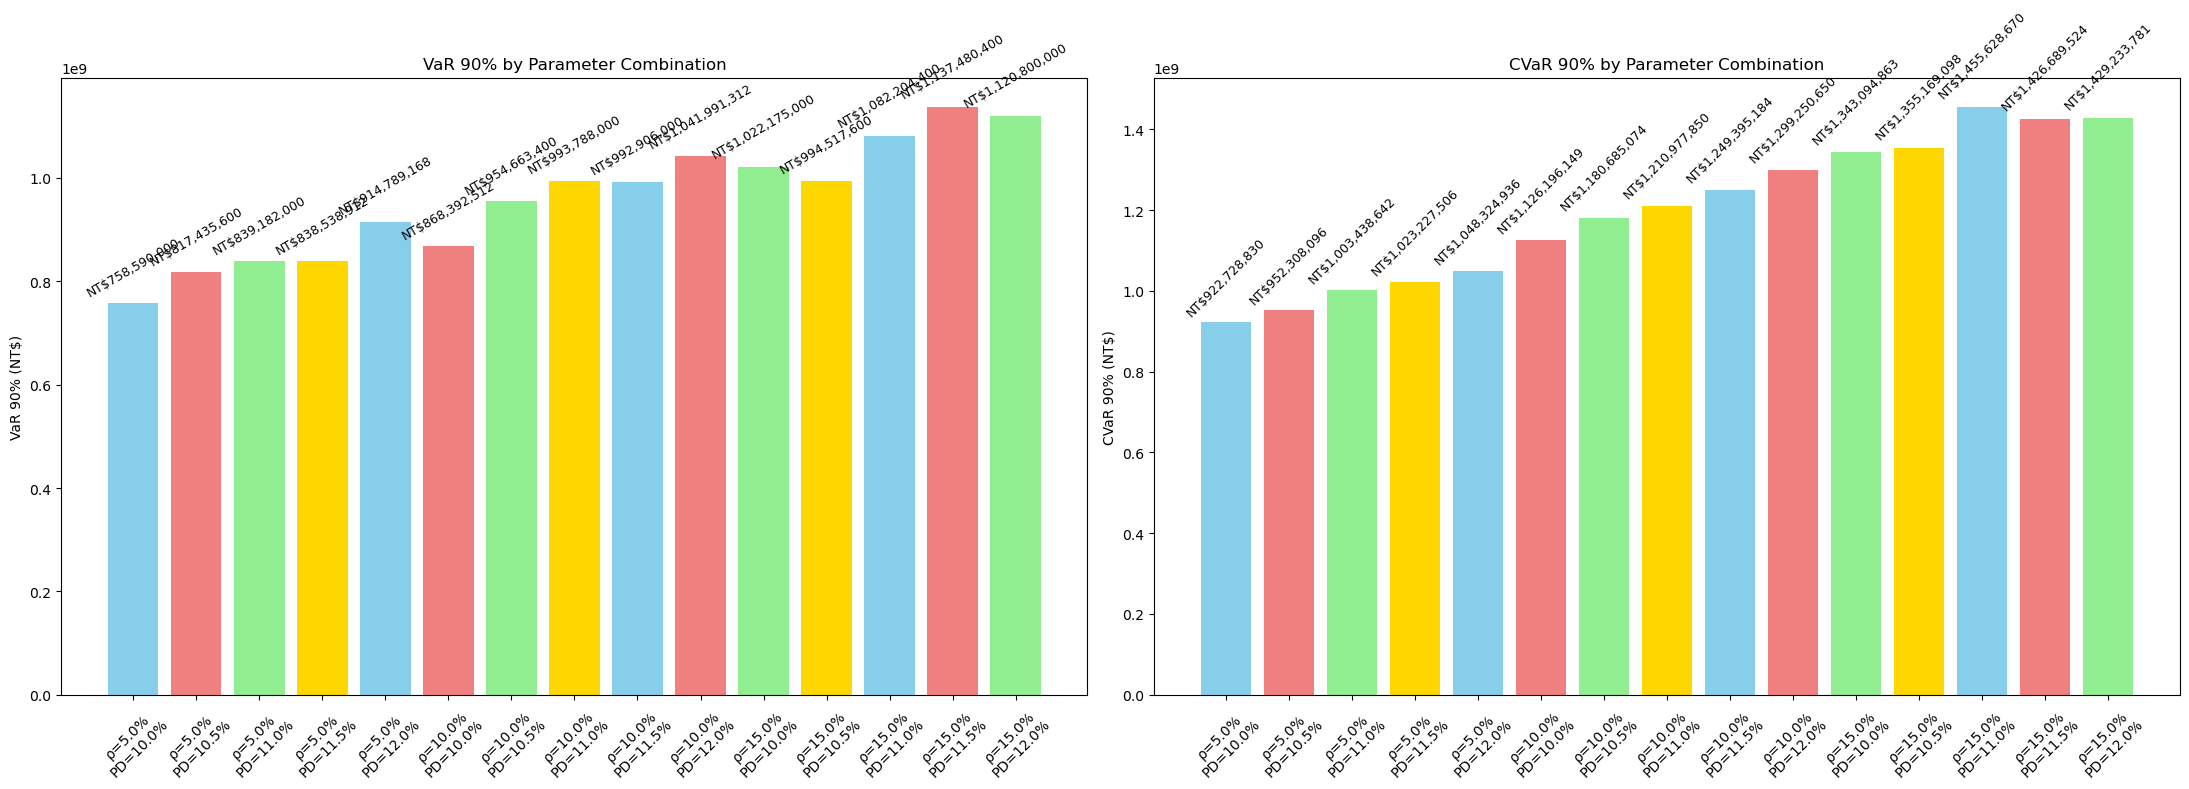

In [10]:
confidence_level = 90

# VaR and CVaR by combination
plt.figure(figsize=(22, 8))

# Subplot 1: VaR by parameter combination
plt.subplot(1, 2, 1)
combinations = [f"ρ={r['correlation']:.1%}\nPD={r['pd']:.1%}" for r in results]
var_values = [r[f"var_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, var_values, color=["skyblue", "lightcoral", "lightgreen", "gold"]
)
plt.ylabel(f"VaR {confidence_level}% (NT$)")
plt.title(f"VaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, var_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=30,
    )

# Subplot 2: CVaR by parameter combination
plt.subplot(1, 2, 2)
cvar_values = [r[f"cvar_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, cvar_values, color=["skyblue", "lightcoral", "lightgreen", "gold"]
)
plt.ylabel(f"CVaR {confidence_level}% (NT$)")
plt.title(f"CVaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, cvar_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=45,
    )

plt.tight_layout()
plt.show()

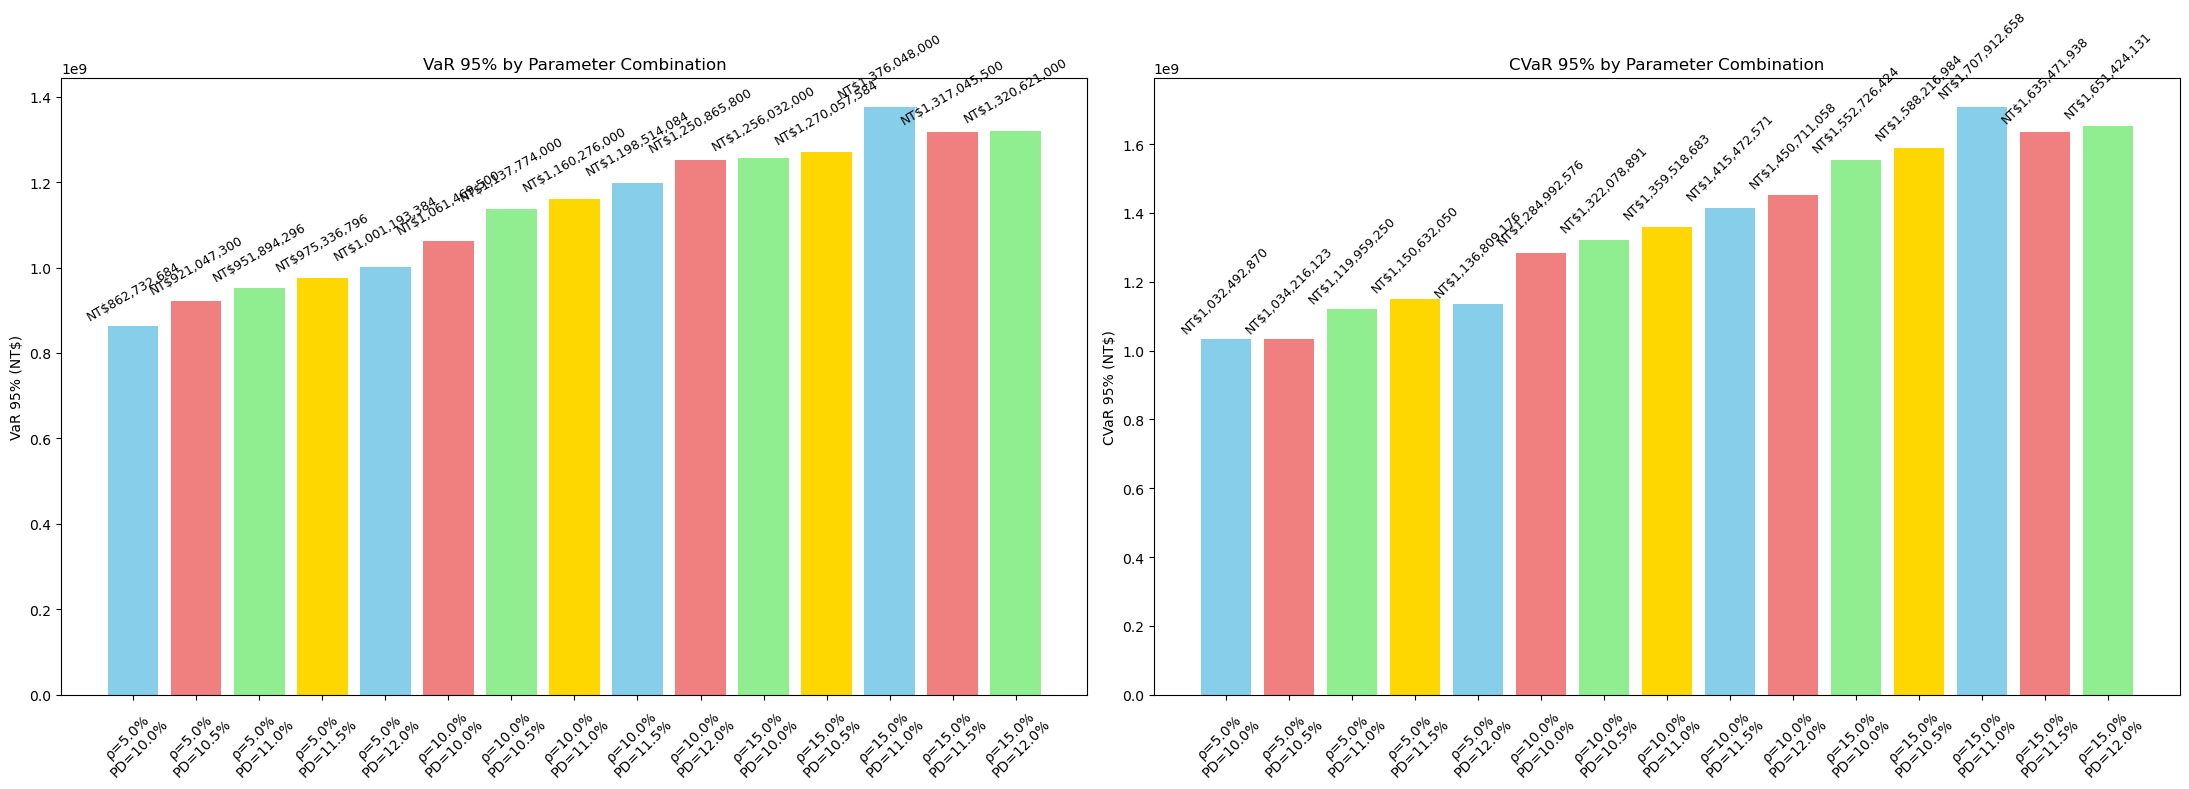

In [11]:
confidence_level = 95

# VaR and CVaR by combination
plt.figure(figsize=(22, 8))

# Subplot 1: VaR by parameter combination
plt.subplot(1, 2, 1)
combinations = [f"ρ={r['correlation']:.1%}\nPD={r['pd']:.1%}" for r in results]
var_values = [r[f"var_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, var_values, color=["skyblue", "lightcoral", "lightgreen", "gold"]
)
plt.ylabel(f"VaR {confidence_level}% (NT$)")
plt.title(f"VaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, var_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=30,
    )

# Subplot 2: CVaR by parameter combination
plt.subplot(1, 2, 2)
cvar_values = [r[f"cvar_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, cvar_values, color=["skyblue", "lightcoral", "lightgreen", "gold"]
)
plt.ylabel(f"CVaR {confidence_level}% (NT$)")
plt.title(f"CVaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, cvar_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=45,
    )

plt.tight_layout()
plt.show()

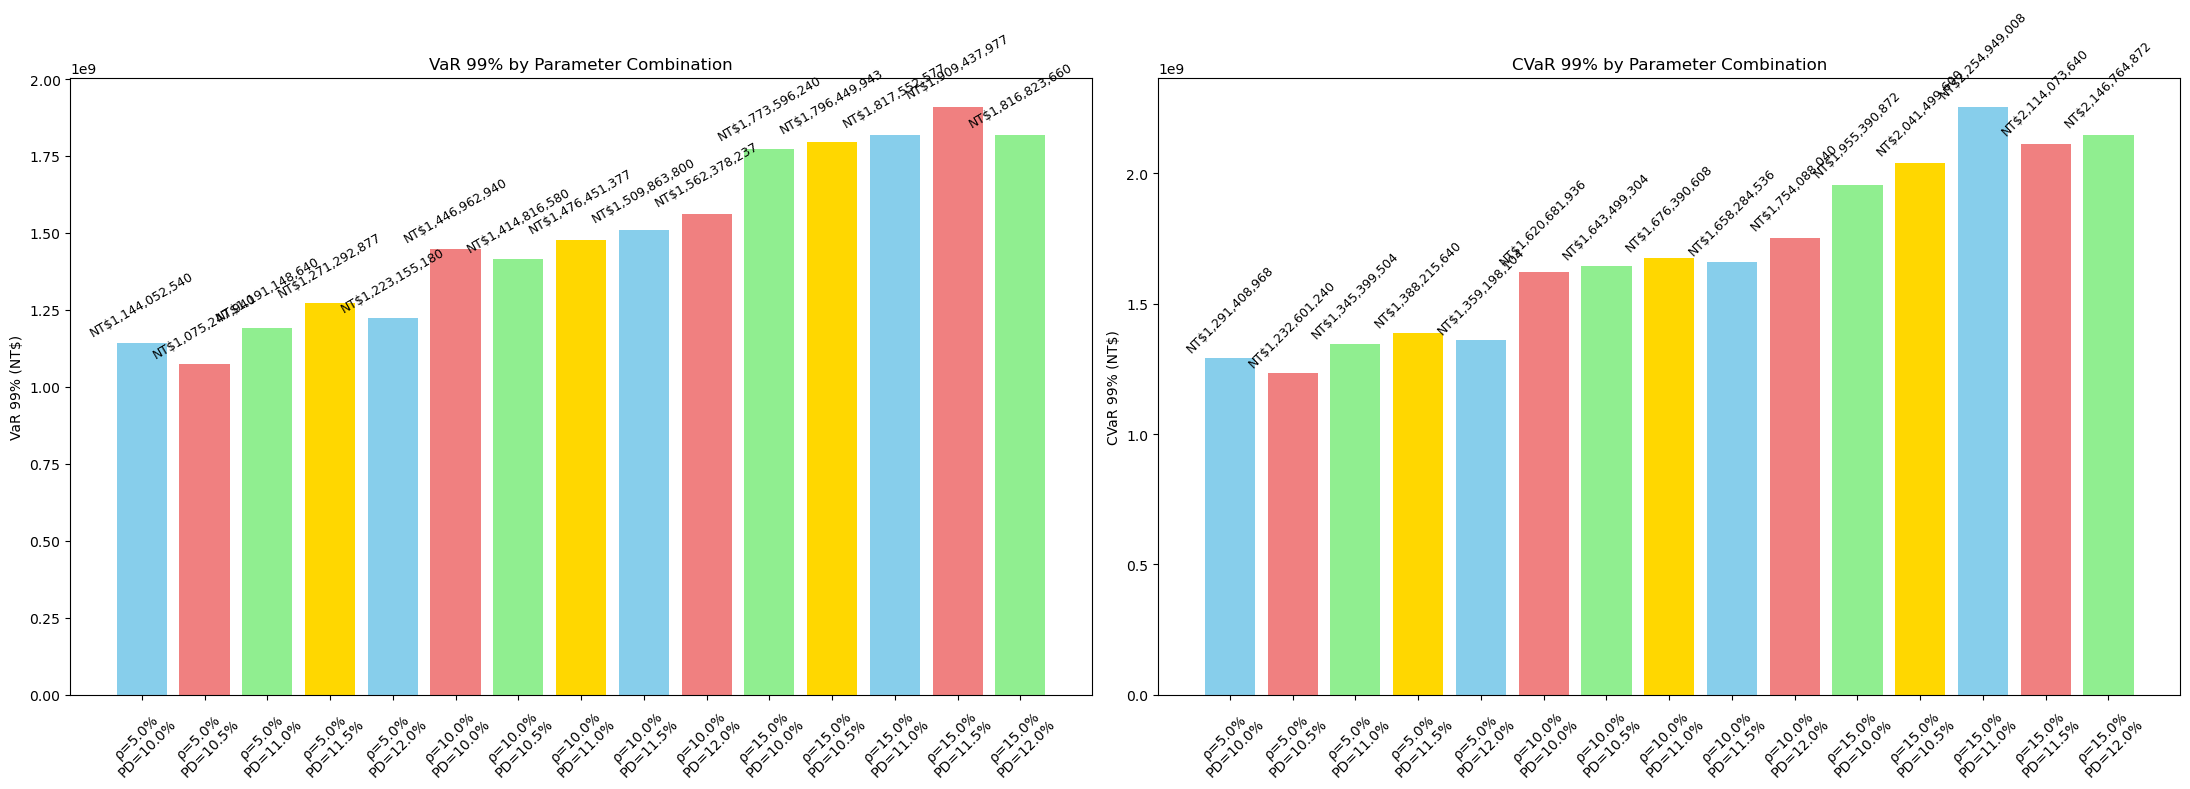

In [12]:
confidence_level = 99

# VaR and CVaR by combination
plt.figure(figsize=(22, 8))

# Subplot 1: VaR by parameter combination
plt.subplot(1, 2, 1)
combinations = [f"ρ={r['correlation']:.1%}\nPD={r['pd']:.1%}" for r in results]
var_values = [r[f"var_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, var_values, color=["skyblue", "lightcoral", "lightgreen", "gold"]
)
plt.ylabel(f"VaR {confidence_level}% (NT$)")
plt.title(f"VaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, var_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=30,
    )

# Subplot 2: CVaR by parameter combination
plt.subplot(1, 2, 2)
cvar_values = [r[f"cvar_{confidence_level}"] for r in results]

bars = plt.bar(
    combinations, cvar_values, color=["skyblue", "lightcoral", "lightgreen", "gold"]
)
plt.ylabel(f"CVaR {confidence_level}% (NT$)")
plt.title(f"CVaR {confidence_level}% by Parameter Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, cvar_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=45,
    )

plt.tight_layout()
plt.show()

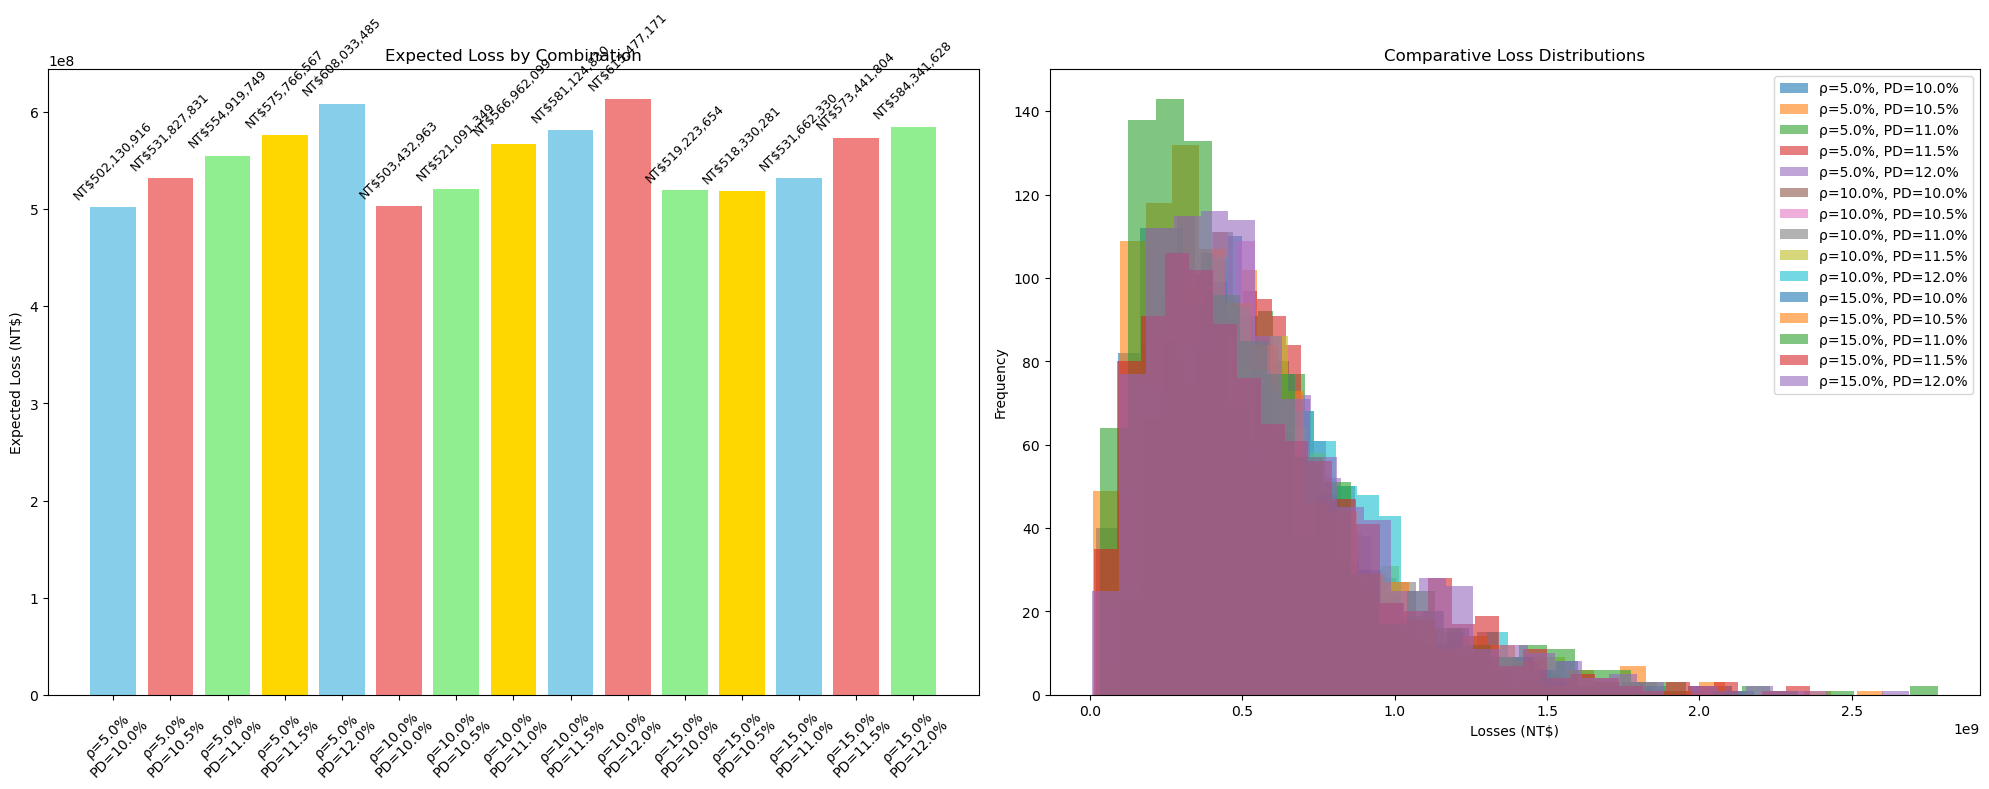

In [13]:
# 2. Expected Loss and Loss Distributions
plt.figure(figsize=(20, 8))

# Subplot 1: Expected Loss by combination
plt.subplot(1, 2, 1)
combinations = [f"ρ={r['correlation']:.1%}\nPD={r['pd']:.1%}" for r in results]
expected_loss_values = [r["expected_loss"] for r in results]

bars = plt.bar(
    combinations,
    expected_loss_values,
    color=["skyblue", "lightcoral", "lightgreen", "gold"],
)
plt.ylabel("Expected Loss (NT$)")
plt.title("Expected Loss by Combination")
plt.xticks(rotation=45)
for bar, value in zip(bars, expected_loss_values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + bar.get_height() * 0.01,
        f"NT${value:,.0f}",
        ha="center",
        va="bottom",
        fontsize=9,
        rotation=45,
    )

# Subplot 2: Comparative Loss Distributions
plt.subplot(1, 2, 2)
for i, result in enumerate(results):
    plt.hist(
        result["total_losses"],
        bins=30,
        alpha=0.6,
        label=f"ρ={result['correlation']:.1%}, PD={result['pd']:.1%}",
    )
plt.xlabel("Losses (NT$)")
plt.ylabel("Frequency")
plt.title("Comparative Loss Distributions")
plt.legend()

plt.tight_layout()
plt.show()

### Summary Table

In [14]:
print(f"\n{'='*100}")
print("COMPREHENSIVE RESULTS SUMMARY")
print(f"{'='*100}")

summary_data = []
for result in results:
    summary_data.append(
        {
            "Correlation": f"{result['correlation']:.1%}",
            "PD": f"{result['pd']:.1%}",
            "Mean Default Rate": f"{result['mean_default_rate']:.2%}",
            "Expected Loss": f"NT${result['expected_loss']:,.0f}",
            "VaR 90%": f"NT${result['var_90']:,.0f}",
            "VaR 95%": f"NT${result['var_95']:,.0f}",
            "VaR 99%": f"NT${result['var_99']:,.0f}",
            "CVaR 90%": f"NT${result['cvar_90']:,.0f}",
            "CVaR 95%": f"NT${result['cvar_95']:,.0f}",
            "CVaR 99%": f"NT${result['cvar_99']:,.0f}",
            "Max Loss": f"NT${result['max_loss']:,.0f}",
        }
    )

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


COMPREHENSIVE RESULTS SUMMARY
Correlation    PD Mean Default Rate  Expected Loss          VaR 90%          VaR 95%          VaR 99%         CVaR 90%         CVaR 95%         CVaR 99%         Max Loss
       5.0% 10.0%             9.99% NT$502,130,916   NT$758,590,000   NT$862,732,684 NT$1,144,052,540   NT$922,728,830 NT$1,032,492,870 NT$1,291,408,968 NT$1,431,266,000
       5.0% 10.5%            10.59% NT$531,827,831   NT$817,435,600   NT$921,047,300 NT$1,075,247,940   NT$952,308,096 NT$1,034,216,123 NT$1,232,601,240 NT$1,563,296,000
       5.0% 11.0%            11.05% NT$554,919,749   NT$839,182,000   NT$951,894,296 NT$1,191,148,640 NT$1,003,438,642 NT$1,119,959,250 NT$1,345,399,504 NT$1,635,816,000
       5.0% 11.5%            11.46% NT$575,766,567   NT$838,538,912   NT$975,336,796 NT$1,271,292,877 NT$1,023,227,506 NT$1,150,632,050 NT$1,388,215,640 NT$1,549,796,000
       5.0% 12.0%            12.10% NT$608,033,485   NT$914,789,168 NT$1,001,193,384 NT$1,223,155,180 NT$1,048,324,936 